### Install & Imports


In [ ]:
%%capture
!pip install einops accelerate biopython

In [ ]:
import transformers
import numpy as np
from transformers import AutoTokenizer,AutoModelForCausalLM,pipeline
from tqdm import tqdm

transformers.logging.set_verbosity_error()


### Parameters selection

In [ ]:
models = [#Pythia
          'EleutherAI/pythia-14m',
          'EleutherAI/pythia-31m',
          'EleutherAI/pythia-70m',
          'EleutherAI/pythia-70m-deduped',
          #TinyStories
          'roneneldan/TinyStories-1M',
          'roneneldan/TinyStories-3M',
          'roneneldan/TinyStories-8M',
          'roneneldan/TinyStories-28M',
          'roneneldan/TinyStories-33M',
          'roneneldan/TinyStories-Instruct-1M',
          'roneneldan/TinyStories-Instruct-3M',
          'roneneldan/TinyStories-Instruct-8M',
          'roneneldan/TinyStories-Instruct-28M',
          'roneneldan/TinyStories-Instruct-33M',
          'roneneldan/TinyStories-1Layer-21M',
          'roneneldan/TinyStories-Instuct-1Layer-21M',
          'roneneldan/TinyStories-2Layers-33M',
          'roneneldan/TinyStories-Instruct-2Layers-33M',
          #Gerbil
          'GerbilLab/Gerbil-A-3.3m',
          'GerbilLab/Gerbil-B-3.3m',
          'GerbilLab/Gerbil-C-3.3m',
          'GerbilLab/Gerbil-D-3.3m',
          'GerbilLab/Gerbil-A-6.7m',
          'GerbilLab/Gerbil-B-6.7m',
          'GerbilLab/Gerbil-C-6.7m',
          'GerbilLab/Gerbil-D-6.7m',
          'GerbilLab/Gerbil-A-15m',
          'GerbilLab/Gerbil-A-32m',
          ]

#Parameters in the paper are G=128 and N=32 but it takes too long to run on collab's free CPU. Feel free to increase these if you run of free GPU or paid collab subscription.
G = 64 #Number of genes
N = 16 #Number of probes

### PhyloLM functions

In [ ]:
#------------------------------------------------------------------------
#
#                 Generate the genome (gene set)
#
#------------------------------------------------------------------------
def generate_genome(models,G,size=16,base=''):
  ''' Returns a genome containing [G] genes made of [size] tokens. Each gene is generated by a uniformely choosen model given in [models] '''
  genome = []
  #Choose the models to sample from and how many times to sample from each of them
  to_sample_from = np.random.choice(models,G)
  models_,counts = np.unique(to_sample_from,return_counts=True)
  #Sample from the models
  for i in tqdm(range(len(models_))):
    tokenizer = AutoTokenizer.from_pretrained(models_[i])
    model = AutoModelForCausalLM.from_pretrained(models_[i],trust_remote_code=True)
    generate = pipeline('text-generation',model=model,tokenizer=tokenizer,device_map='auto')
    out = generate([base for i in range(counts[i])],do_sample=True,min_new_tokens=size,max_new_tokens=size)
    #Store the newly generated genes in the genome
    genome += [out[i][0]['generated_text'] for i in range(counts[i])]
  return np.array(genome)

#------------------------------------------------------------------------
#
#                          PhyloLM functions
#
#------------------------------------------------------------------------

def generate_alleles(model_name,genome,N):
  ''' Generate [N] for each gene given in [genome] for the given model named [model_name]'''
  generate = pipeline('text-generation',model=model_name,trust_remote_code=True,device_map='auto')
  #Duplicate the genome N times
  N_genome = np.repeat(genome[:,None],N,axis=1).flatten()
  #Generate alleles
  N_completions = generate(N_genome.tolist(),do_sample=True,min_new_tokens=4,max_new_tokens=4)
  #Extract alleles
  N_alleles = [compl[0]['generated_text'][len(gene):][:4] for gene,compl in zip(N_genome,N_completions)]
  alleles = np.reshape(N_alleles,genome.shape+(N,))
  return alleles

def compute_P(alleles):
  ''' Compute the population matrix P(allele|gene) from the [alleles] given in input '''
  P = []
  #Count the number of time each allele appears
  for gene_idx in range(len(alleles)):
    d = {}
    for n in range(len(alleles[gene_idx])):
      try:
        d[alleles[gene_idx][n]] += 1
      except KeyError:
        d[alleles[gene_idx][n]] = 1
    #Normalize the counts to frequencies
    for k in d:
      d[k] /=(n+1)
    P.append(d)
  return P

def match(d,k):
  ''' Returns the frequency of allele [k] in population [d] '''
  if k in d:
    return d[k]
  else:
    return 0

def nei_similarity(P1,P2):
  ''' Compute the nei similarity matrix from two given population matrices [P1] and [P2]'''
  up = 0
  dleft = 0
  dright = 0
  for k in range(len(P1)):
    for l in {**P1[k],**P2[k]}:
        up += match(P1[k],l)*match(P2[k],l)
    for l in P1[k]:
        dleft += P1[k][l]**2
    for l in P2[k]:
        dright += P2[k][l]**2
  return up/(dleft*dright)**0.5

def compute_all_P(models,genome,N):
  ''' Compute all population matrices from a given list of [models] on the [genome] for [N] probes '''
  all_P = {}
  for m in tqdm(models):
    # Generate alleles
    alleles = generate_alleles(m,genome,N)
    # Compute P
    P = compute_P(alleles)
    # Store P
    all_P[m] = P
  return all_P

def compute_sim_matrix(models,all_P):
  ''' Compute the Nei similarity matrix between all [models] given their population matrices [all_P] '''
  sim_matrix = np.zeros((len(models),len(models)))
  for i,m1 in enumerate(models):
    for j,m2 in enumerate(models):
      sim_matrix[i][j] = nei_similarity(all_P[m1],all_P[m2])
  return sim_matrix


### Genome computation
In the paper we used benchmarks to construct the genome. Here we present a different method : letting the models generate the genome themselves by sampling a few tokens from an empty context. One model is sampled uniformely among the set of selected models to generate a new gene. This process is iterated G times to generate the full genome.

In [ ]:
genome = generate_genome(models,G,base='')

In [ ]:
#Genome visualization
for i,gene in enumerate(genome):
  print('----- Gene',i,':',gene)

----- Gene 0 :  The purpose of the new and new, technology, technology, technology, technology and
----- Gene 1 : 

I just wanted to talk to you if you're not as a person
----- Gene 2 : Miniiniiniiniiniiniiniiniiniiniiniiniiniiniini
----- Gene 3 : The role of the immune response immune response response system, is one of the therapeutic
----- Gene 4 : #ifndef DIRWIN_H
#define DIRWIN_H

----- Gene 5 : The first report of the discovery that most people, even those who had lost their
----- Gene 6 : !

Heminger Measles

Heminger
----- Gene 7 : .com/newspage/2019-11-15/2018--Katie
----- Gene 8 :  of New York City.

P.I.K.

D
----- Gene 9 :  The book of book

The name of the World News of a New Zealand
----- Gene 10 :  3, 15 1.30 (6.9)
SOTIAS
----- Gene 11 : ) that and the way out with,’/ 

We but
----- Gene 12 : . We to be not be a other a case of the first that I�
----- Gene 13 : -D-D-D-D-D-D-D-D
----- Gene 14 : ... Field of the Invention
The present invention relates relates to a conventi

### Similarity matrix computation

In [ ]:
#Can take a while to run on basic colab CPU. GPU makes it run a lot faster (even the free T4).
all_P = compute_all_P(models,genome,N)
sim_matrix = compute_sim_matrix(models,all_P)

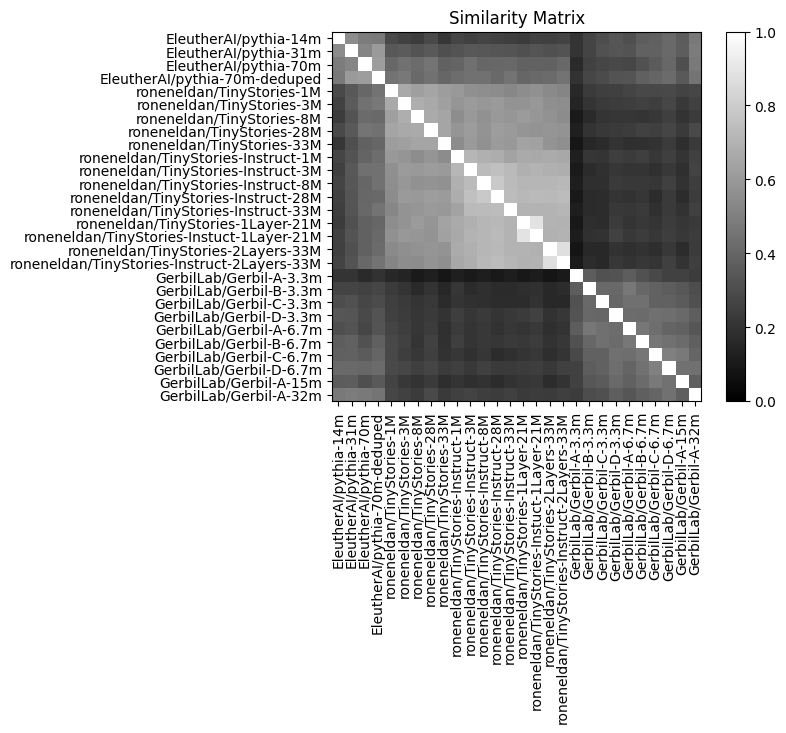

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

im = ax.imshow(sim_matrix,vmin=0,vmax=1,cmap='gray')

ax.set_xticks(range(len(models)))
ax.set_yticks(range(len(models)))
ax.set_xticklabels(models,rotation=90)
ax.set_yticklabels(models)
fig.colorbar(im)
plt.title('Similarity Matrix')
plt.show()

### Phylogenetic Tree plot

- [Pythia](https://github.com/EleutherAI/pythia?tab=readme-ov-file) was trained on [the Pile](https://pile.eleuther.ai/).
- [TinyStories](https://huggingface.co/roneneldan/TinyStories-33M) was trained on the [TinyStories dataset](https://huggingface.co/datasets/roneneldan/TinyStories).
- [Gerbil](https://github.com/aicrumb/notebook-hosting/blob/main/GerbilLabEvaluations.md) was trained on the [deduplicated The Pile dataset](https://huggingface.co/datasets/EleutherAI/the_pile_deduplicated).


In [ ]:
colors = {'pythia':'green','tinystories':'red','gerbil':'blue'}
def prepare_tree(tree,origins):
    global colors
    for clade in tree.find_clades():
        if clade.name and clade.name.startswith('Inner'):
            clade.name = None
        if clade.name is None:
            continue
        index = [m for m in models].index(clade.name)
        clade_family = origins[index]
        clade.color = colors[clade_family.split(' ')[0]]
        #if 'gpt' in clade_family:
        #    clade.color = colors_gpt[clade_family]
    for clade in tree.find_clades():
      if clade.name and clade.name.startswith('Inner'):
        clade.name = None
    #If clade has all its children with the same color, make the clade to this color
    all_clades = tree.find_clades()
    clades = []
    for clade in all_clades:
        clade.locked = False
        if clade.color is None:
            clades.append(clade)
    i = 0
    while len(clades) > 0:
        clade = clades[i%len(clades)]
        colors = [(c.color.red,c.color.green,c.color.blue) for c in clade.clades if not(c.color is None)]
        locked = any([c.locked for c in clade.clades])
        if len(set(colors)) == 1 and len(colors) == len(clade.clades):
            clade.color = colors[0]
            del clades[i%len(clades)]
        elif len(set(colors))>1:
            clade.locked = True
            del clades[i%len(clades)]
        elif locked:
            clade.locked = True
            del clades[i%len(clades)]
        i += 1

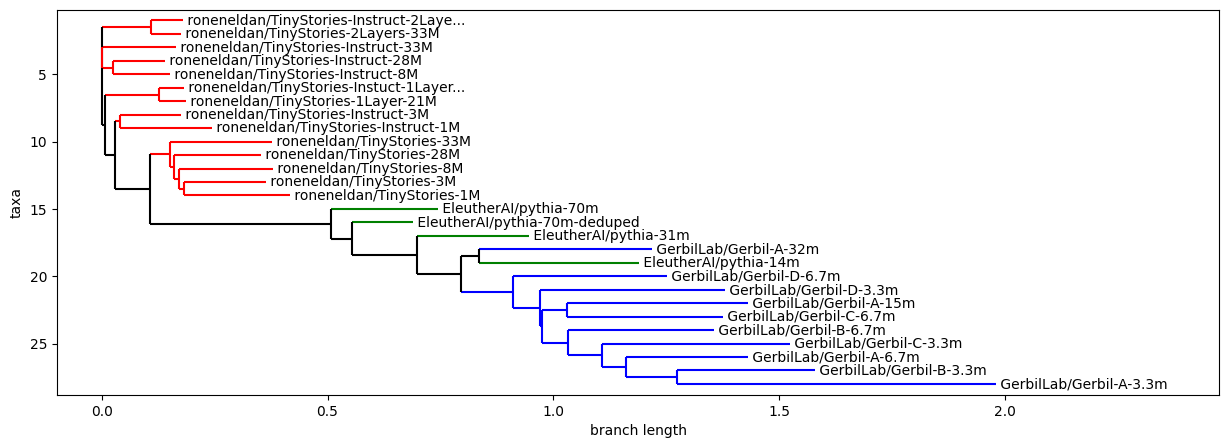

In [ ]:
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceCalculator, DistanceMatrix

calculator = DistanceCalculator('identity')
constructor = DistanceTreeConstructor(calculator, 'nj')

#Here you can choose to only include a subset of all the models
kept_models = [
          #Pythia
          'EleutherAI/pythia-14m',
          'EleutherAI/pythia-31m',
          'EleutherAI/pythia-70m',
          'EleutherAI/pythia-70m-deduped',
          #TinyStories
          'roneneldan/TinyStories-1M',
          'roneneldan/TinyStories-3M',
          'roneneldan/TinyStories-8M',
          'roneneldan/TinyStories-28M',
          'roneneldan/TinyStories-33M',
          'roneneldan/TinyStories-Instruct-1M',
          'roneneldan/TinyStories-Instruct-3M',
          'roneneldan/TinyStories-Instruct-8M',
          'roneneldan/TinyStories-Instruct-28M',
          'roneneldan/TinyStories-Instruct-33M',
          'roneneldan/TinyStories-1Layer-21M',
          'roneneldan/TinyStories-Instuct-1Layer-21M',
          'roneneldan/TinyStories-2Layers-33M',
          'roneneldan/TinyStories-Instruct-2Layers-33M',
          #Gerbil
          'GerbilLab/Gerbil-A-3.3m',
          'GerbilLab/Gerbil-B-3.3m',
          'GerbilLab/Gerbil-C-3.3m',
          'GerbilLab/Gerbil-D-3.3m',
          'GerbilLab/Gerbil-A-6.7m',
          'GerbilLab/Gerbil-B-6.7m',
          'GerbilLab/Gerbil-C-6.7m',
          'GerbilLab/Gerbil-D-6.7m',
          'GerbilLab/Gerbil-A-15m',
          'GerbilLab/Gerbil-A-32m',
          ]

origins = []
for m in kept_models:
  if 'pythia' in m:
    origins.append('pythia')
  elif 'TinyStories' in m:
    origins.append('tinystories')
  elif 'Gerbil' in m:
    origins.append('gerbil')
  else:
    assert False #Origin of the model not found

indexs = [models.index(kept_models[i]) for i in range(len(kept_models))]
#If you have 0 in the sim matrix the distance matrix computation with fail as it computes log(0).
#This can be fixed by adding an epsilon to the sim_matrix but will not yield very relevant results in the phylogenetic tree.
#Ideally the solution is to first check the completions of the models in all_P to check for errors in the way the LLM fills the genes.
#If everything is correct but completions are too different between the models, find a larger genome and increase N seem to yield better results than adding an epsilon
#to patch the problem.
dist_matrix = -np.log(np.maximum(sim_matrix,1e-3))

kept_dist_matrix = dist_matrix[indexs][:,indexs]

low_triangle_kl_mean = [[kept_dist_matrix[i][j] for j in range(i+1)] for i in range(len(kept_dist_matrix))]

df = DistanceMatrix(names=[m for m in kept_models],matrix=low_triangle_kl_mean)
NJTree = constructor.nj(df)
NJTree.ladderize(reverse=False)

prepare_tree(NJTree,origins)

plt.figure(figsize=(15,5))
axes = plt.gca()
Phylo.draw(NJTree,axes=axes,do_show=False)
